## micro price replication 
1. symmetrize data
    - (It,St,It+1,St+1,dM) ==> (1-It,St,1-It+1,St+1,-dM)
2. Estimate Q, T, R
3. Calculate G1
4. Calculate G* ==> micro price adjustment 


In [237]:
# load libraries 
import math
import decimal 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from scipy.linalg import block_diag
from scipy.linalg import eig



In [136]:
# load data 
df_data = pd.read_csv('eth_btc_coinbase.csv.gz', compression='gzip')

# split the price and volume 
df_data[["bid_price", "bid_size"]] = df_data["bid_price_bid_size"].str.split(pat="_", expand=True).astype(float)
df_data[["ask_price", "ask_size"]] = df_data["ask_price_ask_size"].str.split(pat="_", expand=True).astype(float)

# drop original 
df_data = df_data.drop(["bid_price_bid_size", "ask_price_ask_size"], axis=1)

print(df_data.describe())

       time_seconds     bid_price      bid_size     ask_price      ask_size
count  6.421900e+04  64219.000000  6.421900e+04  64219.000000  6.421900e+04
mean   1.645187e+09      0.070702  3.695460e+00      0.070724  4.204517e+00
std    2.502535e+04      0.000896  4.623886e+00      0.000896  5.574467e+00
min    1.645142e+09      0.069090  5.300000e-07      0.069110  1.000000e-08
25%    1.645165e+09      0.069650  6.856072e-01      0.069670  6.625433e-01
50%    1.645190e+09      0.071160  1.855571e+00      0.071180  1.690164e+00
75%    1.645208e+09      0.071480  5.790559e+00      0.071500  6.611159e+00
max    1.645229e+09      0.071920  1.016001e+02      0.071930  4.891600e+01


In [157]:
# Inputs 

# the states should be explicitly evaluated 

# number of imbalance 
n_imb = 7
# number of spread 
n_spread = 2
# delta t 
dt = 1

# tick size 
ticksize = 10**(-5)

# grid of mid price change 
K = np.array([-0.01, -0.005, 0.005, 0.01])

In [138]:
# calculate relevant indictors 

# spread in terms of tick 
df_data['spread'] = np.round((df_data['ask_price'] - df_data['bid_price']) / ticksize) * ticksize

# mid price
df_data['mid'] = (df_data['ask_price'] + df_data['bid_price'])/2

# weighed mid price 
df_data['wmid'] = (
    (df_data['ask_price'] * df_data['bid_size'] + df_data['bid_price']*df_data['ask_size'])
    / (df_data['ask_size'] + df_data['bid_size'])
)
# # mid price returns 
# df_data['MidPriceReturn'] = df_data['MidPrice'].pct_change()

# # tick size 
# ticksize = min(df_data['Spread'].loc[df_data['Spread']>0])

# orderbook imbalance 
df_data["imb"] = df_data["bid_size"] / (df_data["bid_size"] + df_data["ask_size"])

# discretize imbalance into percentiles
df_data['imb_bucket'] = pd.qcut(df_data['imb'], n_imb, labels=False)

# next
df_data['next_mid'] = df_data['mid'].shift(-dt)
df_data['next_wmid'] = df_data['wmid'].shift(-dt)
df_data['next_spread'] = df_data['spread'].shift(-dt)
df_data['next_imb_bucket'] = df_data['imb_bucket'].shift(-dt)

# mid price difference -- half tick 
df_data["dM"] = np.round((df_data['next_mid'] - df_data['mid']) / ticksize * 2) * ticksize / 2
# weighted mid price difference -- half tick 
df_data["dwM"] = np.round((df_data['next_wmid'] - df_data['wmid']) / ticksize * 2) * ticksize / 2

df_data



,time_seconds,bid_price,bid_size,ask_price,ask_size,spread,mid,wmid,imb,imb_bucket,next_mid,next_wmid,next_spread,next_imb_bucket,dM,dwM
0,1645142400,0.07137,1.863301,0.07139,0.950000,0.00002,0.071380,0.071383,0.662318,4,0.071385,0.071380,0.00001,0.0,0.000005,-0.000005
1,1645142401,0.07138,0.499840,0.07139,18.225881,0.00001,0.071385,0.071380,0.026693,0,0.071380,0.071371,0.00002,0.0,-0.000005,-0.000010
2,1645142403,0.07137,0.499840,0.07139,18.225881,0.00002,0.071380,0.071371,0.026693,0,0.071380,0.071380,0.00002,3.0,0.000000,0.000010
3,1645142404,0.07137,0.914646,0.07139,0.950000,0.00002,0.071380,0.071380,0.490520,3,0.071380,0.071371,0.00002,0.0,0.000000,-0.000010
4,1645142405,0.07137,0.499840,0.07139,18.571515,0.00002,0.071380,0.071371,0.026209,0,0.071380,0.071371,0.00002,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64214,1645228793,0.06950,1.549840,0.06951,3.821804,0.00001,0.069505,0.069503,0.288522,2,0.069505,0.069503,0.00001,2.0,0.000000,0.000000
64215,1645228794,0.06950,1.549840,0.06951,3.820255,0.00001,0.069505,0.069503,0.288606,2,0.069505,0.069505,0.00001,3.0,0.000000,0.000000
64216,1645228796,0.06950,2.221340,0.06951,2.644555,0.00001,0.069505,0.069505,0.456512,3,0.069505,0.069506,0.00001,4.0,0.000000,0.000000
64217,1645228797,0.06950,4.066678,0.06951,2.644555,0.00001,0.069505,0.069506,0.605951,4,0.069505,0.069506,0.00001,3.0,0.000000,-0.000000


In [139]:
# filter out spreads >= n_spread
df_data = df_data.loc[(df_data["spread"] <= n_spread * ticksize)]
# filter out dM > 1.1 * ticksize
df_data = df_data.loc[(df_data["dM"] <= ticksize*1.1) & (df_data["dM"] >= -ticksize*1.1)]

df_data

,time_seconds,bid_price,bid_size,ask_price,ask_size,spread,mid,wmid,imb,imb_bucket,next_mid,next_wmid,next_spread,next_imb_bucket,dM,dwM
0,1645142400,0.07137,1.863301,0.07139,0.950000,0.00002,0.071380,0.071383,0.662318,4,0.071385,0.071380,0.00001,0.0,0.000005,-0.000005
1,1645142401,0.07138,0.499840,0.07139,18.225881,0.00001,0.071385,0.071380,0.026693,0,0.071380,0.071371,0.00002,0.0,-0.000005,-0.000010
2,1645142403,0.07137,0.499840,0.07139,18.225881,0.00002,0.071380,0.071371,0.026693,0,0.071380,0.071380,0.00002,3.0,0.000000,0.000010
3,1645142404,0.07137,0.914646,0.07139,0.950000,0.00002,0.071380,0.071380,0.490520,3,0.071380,0.071371,0.00002,0.0,0.000000,-0.000010
4,1645142405,0.07137,0.499840,0.07139,18.571515,0.00002,0.071380,0.071371,0.026209,0,0.071380,0.071371,0.00002,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64213,1645228792,0.06950,0.499840,0.06951,3.821804,0.00001,0.069505,0.069501,0.115660,1,0.069505,0.069503,0.00001,2.0,0.000000,0.000000
64214,1645228793,0.06950,1.549840,0.06951,3.821804,0.00001,0.069505,0.069503,0.288522,2,0.069505,0.069503,0.00001,2.0,0.000000,0.000000
64215,1645228794,0.06950,1.549840,0.06951,3.820255,0.00001,0.069505,0.069503,0.288606,2,0.069505,0.069505,0.00001,3.0,0.000000,0.000000
64216,1645228796,0.06950,2.221340,0.06951,2.644555,0.00001,0.069505,0.069505,0.456512,3,0.069505,0.069506,0.00001,4.0,0.000000,0.000000


In [140]:
# 1. symmetrize data
#    - (It,St,It+1,St+1,dM) ==> (1-It,St,1-It+1,St+1,-dM)

df_data_symm = df_data.copy(deep=True)
df_data_symm['imb_bucket'] = n_imb - 1 - df_data_symm['imb_bucket']
df_data_symm['next_imb_bucket'] = n_imb - 1 - df_data_symm['next_imb_bucket']
df_data_symm['dM'] = -df_data_symm['dM']

df_data = pd.concat([df_data, df_data_symm])
df_data

,time_seconds,bid_price,bid_size,ask_price,ask_size,spread,mid,wmid,imb,imb_bucket,next_mid,next_wmid,next_spread,next_imb_bucket,dM,dwM
0,1645142400,0.07137,1.863301,0.07139,0.950000,0.00002,0.071380,0.071383,0.662318,4,0.071385,0.071380,0.00001,0.0,0.000005,-0.000005
1,1645142401,0.07138,0.499840,0.07139,18.225881,0.00001,0.071385,0.071380,0.026693,0,0.071380,0.071371,0.00002,0.0,-0.000005,-0.000010
2,1645142403,0.07137,0.499840,0.07139,18.225881,0.00002,0.071380,0.071371,0.026693,0,0.071380,0.071380,0.00002,3.0,0.000000,0.000010
3,1645142404,0.07137,0.914646,0.07139,0.950000,0.00002,0.071380,0.071380,0.490520,3,0.071380,0.071371,0.00002,0.0,0.000000,-0.000010
4,1645142405,0.07137,0.499840,0.07139,18.571515,0.00002,0.071380,0.071371,0.026209,0,0.071380,0.071371,0.00002,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64213,1645228792,0.06950,0.499840,0.06951,3.821804,0.00001,0.069505,0.069501,0.115660,5,0.069505,0.069503,0.00001,4.0,-0.000000,0.000000
64214,1645228793,0.06950,1.549840,0.06951,3.821804,0.00001,0.069505,0.069503,0.288522,4,0.069505,0.069503,0.00001,4.0,-0.000000,0.000000
64215,1645228794,0.06950,1.549840,0.06951,3.820255,0.00001,0.069505,0.069503,0.288606,4,0.069505,0.069505,0.00001,3.0,-0.000000,0.000000
64216,1645228796,0.06950,2.221340,0.06951,2.644555,0.00001,0.069505,0.069505,0.456512,3,0.069505,0.069506,0.00001,2.0,-0.000000,0.000000


In [217]:
# 2. Estimate Q, T, R

# Q ==> transient matrix, 顺态矩阵 [nm * nm] 
# Xt := (It,St)
# probability that mid_price dont change, known Xt, Xt+1

# locate all that don't move 
no_move = df_data[df_data['dM'] == 0]

# count 
# no need to use next_spread, coz mid_price not move, next_spread should stay the same 
no_move_counts = no_move.pivot_table(index=['next_imb_bucket'], 
                                     columns=['spread', 'imb_bucket'], 
                                     values='time_seconds',
                                     fill_value=0, 
                                     aggfunc='count').unstack()

# resize to [n * n] ==> first matrix when m=1 
Q_counts = np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]), (n_imb,n_imb))

# loop over all spreads and add block matrices
for i in range(1,n_spread):
    Qi = np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
    Q_counts = block_diag(Q_counts, Qi)
        
print(Q_counts.shape)

# T ==> transient matrix, 顺态矩阵 [nm * nm] 
# Xt := (It,St)
# probability that mid_price do change, known Xt, Xt+1

# locate all that move 
do_move = df_data[df_data['dM'] != 0]

# count all moves 
# 必须要对齐，index, columns 位置要正确
move_counts = do_move.pivot_table(index=['spread', 'imb_bucket'], 
                                  columns=['next_spread', 'next_imb_bucket'], 
                                  values='time_seconds',
                                  fill_value=0, 
                                  aggfunc='count')
# R2 = T 
# resize to [nm * nm] 
R2_counts = np.resize(np.array(move_counts), (n_imb*n_spread, n_imb*n_spread))

# R ==> absorbing states, [nm * 4]

move_counts2 = do_move.pivot_table(index=['dM'], 
                                   columns=['spread', 'imb_bucket'], 
                                   values='time_seconds',
                                   fill_value=0, 
                                   aggfunc='count').unstack()

R_counts = np.resize(np.array(move_counts2), (n_imb*n_spread,4))
print(R_counts.shape)
print(no_move_counts)
print(move_counts)


(14, 14)
(14, 4)
spread   imb_bucket  next_imb_bucket
0.00001  0           0.0                1307
                     1.0                  61
                     2.0                  48
                     3.0                  31
                     4.0                  19
                                        ... 
0.00002  6           2.0                 247
                     3.0                 362
                     4.0                 673
                     5.0                1409
                     6.0                5792
Length: 98, dtype: int64
next_spread        0.00001                               0.00002            \
next_imb_bucket        0.0  1.0  2.0  3.0  4.0  5.0  6.0     0.0  1.0  2.0   
spread  imb_bucket                                                           
0.00001 0               23   11   10   21   14   10    6     334  165  104   
        1                8    5    4    7    7    5    5     128   93   86   
        2                9    1    5

In [220]:
# T1 = [Q_counts, R_counts]
# combine them and calculate probability from count 
T1 = np.concatenate((Q_counts, R_counts), axis=1).astype(float)
print(T1.shape)

# probability known Xt, Xt+1 = (count_i) / (count_dont_move + count_move)
for i in range(0, n_imb*n_spread):
    T1[i, :] = T1[i, :] / T1[i, :].sum()

# return Q, R1 in probability 
Q = T1[:,0:(n_imb*n_spread)]
R1 = T1[:,(n_imb*n_spread):]

# T2 = [Q_counts, R2_counts]
# combine them and calculate probability from count 
T2 = np.concatenate((Q_counts, R2_counts), axis=1).astype(float)
print(T2.shape)

# probability known Xt, Xt+1 = (count_i) / (count_dont_move + count_move)
for i in range(0, n_imb*n_spread):
    T2[i, :] = T2[i, :] / T2[i, :].sum()

R2 = T2[:, (n_imb*n_spread):]
Q2 = T2[:, 0:(n_imb*n_spread)]


(14, 18)
(14, 28)


In [222]:
# 3. Calculate G1 [nm * 1]
# G1 = (1-Q)**-1 * R * K 
G1 = np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread) - Q), R1), K)
G1


array([-1.89950908e-03, -1.35549390e-03, -7.48902107e-04, -2.16840434e-19,
        7.48902107e-04,  1.35549390e-03,  1.89950908e-03, -3.13037999e-03,
       -1.71993506e-03, -7.99855434e-04,  0.00000000e+00,  7.99855434e-04,
        1.71993506e-03,  3.13037999e-03])

In [226]:
# 4. Calculate G* ==> micro price adjustment 

# B = (1-Q)**-1 * R2 [nm*nm]
B = np.dot(np.linalg.inv( np.eye(n_imb*n_spread) - Q), R2)
B.shape



### Check the functions 
from https://github.com/shaileshkakkar/MicroPriceIndicator/blob/master/Micro-Price%20Reproduction.ipynb, 
we got the script. we check our estimations are similar compared to theirs 


In [274]:
# Function to estimate transition probabiliies 
# our function

def estimate_transi_prob(df_data, K):
    # 2. Estimate Q, T, R

    # Q ==> transient matrix, 顺态矩阵 [nm * nm] 
    # Xt := (It,St)
    # probability that mid_price dont change, known Xt, Xt+1

    # locate all that don't move 
    no_move = df_data[df_data['dM'] == 0]

    # count 
    # no need to use next_spread, coz mid_price not move, next_spread should stay the same 
    no_move_counts = no_move.pivot_table(index=['next_imb_bucket'], 
                                         columns=['spread', 'imb_bucket'], 
                                         values='time_seconds',
                                         fill_value=0, 
                                         aggfunc='count').unstack()

    # resize to [n * n] ==> first matrix when m=1 
    Q_counts = np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]), (n_imb,n_imb))

    # loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi = np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
        Q_counts = block_diag(Q_counts, Qi)

    # T ==> transient matrix, 顺态矩阵 [nm * nm] 
    # Xt := (It,St)
    # probability that mid_price do change, known Xt, Xt+1

    # locate all that move 
    do_move = df_data[df_data['dM'] != 0]

    # count all moves 
    # 必须要对齐，index, columns 位置要正确
    move_counts = do_move.pivot_table(index=['spread', 'imb_bucket'], 
                                      columns=['next_spread', 'next_imb_bucket'], 
                                      values='time_seconds',
                                      fill_value=0, 
                                      aggfunc='count')
    # R2 = T 
    # resize to [nm * nm] 
    R2_counts = np.resize(np.array(move_counts), (n_imb*n_spread, n_imb*n_spread))

    # R ==> absorbing states, [nm * 4]
    move_counts2 = do_move.pivot_table(index=['dM'], 
                                       columns=['spread', 'imb_bucket'], 
                                       values='time_seconds',
                                       fill_value=0, 
                                       aggfunc='count').unstack()

    R_counts = np.resize(np.array(move_counts2), (n_imb*n_spread,4))
    
    # T1 = [Q_counts, R_counts]
    # combine them and calculate probability from count 
    T1 = np.concatenate((Q_counts, R_counts), axis=1).astype(float)

    # probability known Xt, Xt+1 = (count_i) / (count_dont_move + count_move)
    for i in range(0, n_imb*n_spread):
        T1[i, :] = T1[i, :] / T1[i, :].sum()

    # return Q, R1 in probability 
    Q = T1[:,0:(n_imb*n_spread)]
    R1 = T1[:,(n_imb*n_spread):]

    # T2 = [Q_counts, R2_counts]
    # combine them and calculate probability from count 
    T2 = np.concatenate((Q_counts, R2_counts), axis=1).astype(float)

    # probability known Xt, Xt+1 = (count_i) / (count_dont_move + count_move)
    for i in range(0, n_imb*n_spread):
        T2[i, :] = T2[i, :] / T2[i, :].sum()

    R2 = T2[:, (n_imb*n_spread):]
    Q2 = T2[:, 0:(n_imb*n_spread)]
    
    # 3. Calculate G1 [nm * 1]
    # G1 = (1-Q)**-1 * R * K 
    G1 = np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread) - Q), R1), K)
    
    # 4. Calculate G* ==> micro price adjustment 
    # B = (1-Q)**-1 * R2 [nm*nm]
    B = np.dot(np.linalg.inv( np.eye(n_imb*n_spread) - Q), R2)
    
    return G1,B,Q,Q2,R1,R2


In [275]:
# Function to estimate transition probabiliies 
# from https://github.com/shaileshkakkar/MicroPriceIndicator/blob/master/Micro-Price%20Reproduction.ipynb

def estimate_old(T):
    no_move=T[T['dM']==0]
    no_move_counts=no_move.pivot_table(index=[ 'next_imb_bucket'], 
                     columns=['spread', 'imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count').unstack()

    #print no_move_counts
    Q_counts=np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]),(n_imb,n_imb))
    # loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
        Q_counts=block_diag(Q_counts,Qi)
    #print Q_counts
    move_counts=T[(T['dM']!=0)].pivot_table(index=['dM'], 
                         columns=['spread', 'imb_bucket'], 
                         values='time',
                         fill_value=0, 
                         aggfunc='count').unstack()

    R_counts=np.resize(np.array(move_counts),(n_imb*n_spread,4))
    T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
    for i in range(0,n_imb*n_spread):
        T1[i]=T1[i]/T1[i].sum()
    Q=T1[:,0:(n_imb*n_spread)]
    R1=T1[:,(n_imb*n_spread):]

    move_counts=T[(T['dM']!=0)].pivot_table(index=['spread','imb_bucket'], 
                     columns=['next_spread', 'next_imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count') #.unstack()

    R2_counts=np.resize(np.array(move_counts),(n_imb*n_spread,n_imb*n_spread))
    T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)

    for i in range(0,n_imb*n_spread):
        T2[i]=T2[i]/T2[i].sum()
    R2=T2[:,(n_imb*n_spread):]
    Q2=T2[:,0:(n_imb*n_spread)]
    G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
    B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)
    
    return G1,B,Q,Q2,R1,R2,K

In [246]:
# modify names 
df_T = df_data.copy(deep=True)
df_T.rename(columns={'bid_price': 'bid'}, inplace=True)
df_T.rename(columns={'ask_price': 'ask'}, inplace=True)
df_T.rename(columns={'ask_size': 'as'}, inplace=True)
df_T.rename(columns={'bid_size': 'bs'}, inplace=True)
df_T.rename(columns={'time_seconds': 'time'}, inplace=True)
df_T

,time,bid,bs,ask,as,spread,mid,wmid,imb,imb_bucket,next_mid,next_wmid,next_spread,next_imb_bucket,dM,dwM
0,1645142400,0.07137,1.863301,0.07139,0.950000,0.00002,0.071380,0.071383,0.662318,4,0.071385,0.071380,0.00001,0.0,0.000005,-0.000005
1,1645142401,0.07138,0.499840,0.07139,18.225881,0.00001,0.071385,0.071380,0.026693,0,0.071380,0.071371,0.00002,0.0,-0.000005,-0.000010
2,1645142403,0.07137,0.499840,0.07139,18.225881,0.00002,0.071380,0.071371,0.026693,0,0.071380,0.071380,0.00002,3.0,0.000000,0.000010
3,1645142404,0.07137,0.914646,0.07139,0.950000,0.00002,0.071380,0.071380,0.490520,3,0.071380,0.071371,0.00002,0.0,0.000000,-0.000010
4,1645142405,0.07137,0.499840,0.07139,18.571515,0.00002,0.071380,0.071371,0.026209,0,0.071380,0.071371,0.00002,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64213,1645228792,0.06950,0.499840,0.06951,3.821804,0.00001,0.069505,0.069501,0.115660,5,0.069505,0.069503,0.00001,4.0,-0.000000,0.000000
64214,1645228793,0.06950,1.549840,0.06951,3.821804,0.00001,0.069505,0.069503,0.288522,4,0.069505,0.069503,0.00001,4.0,-0.000000,0.000000
64215,1645228794,0.06950,1.549840,0.06951,3.820255,0.00001,0.069505,0.069503,0.288606,4,0.069505,0.069505,0.00001,3.0,-0.000000,0.000000
64216,1645228796,0.06950,2.221340,0.06951,2.644555,0.00001,0.069505,0.069505,0.456512,3,0.069505,0.069506,0.00001,2.0,-0.000000,0.000000


In [277]:
K = np.array([-0.01, -0.005, 0.005, 0.01])
K = np.array([-0.1, -0.05, 0.05, 0.1])

# our estimation
G1,B,Q,Q2,R1,R2, = estimate_transi_prob(df_data, K)
# estimation from github 
G1_,B_,Q_,Q2_,R1_,R2_,K = estimate_old(df_T)
(G1_==G1).all(),(B_ == B).all(), (Q_ == Q).all(), (R1_ == R1).all(), (R2_ == R2).all()

(True, True, True, True, True)

### Results

In [278]:
# calculate price impact 
G2=np.dot(B,G1)+G1
G3=G2+np.dot(np.dot(B,B),G1)
G4=G3+np.dot(np.dot(np.dot(B,B),B),G1)
G5=G4+np.dot(np.dot(np.dot(np.dot(B,B),B),B),G1)
G6=G5+np.dot(np.dot(np.dot(np.dot(np.dot(B,B),B),B),B),G1)

# check convergence 
[dG * 10000 for dG in [G2-G1, G3-G2, G4-G3, G5-G4, G6-G5]]

[array([-93.47601174,  -4.52767739,  -8.37082115,  -3.63883025,
        -16.7526663 ,  -8.17809983, -22.7305931 ,   4.69202258,
         -2.51752653,   5.67454709,  -6.53643416,   4.18222836,
        -14.00139046,  -9.20647487]),
 array([ -2.84001197,  -4.07961765,  -4.65133825,  -3.37115095,
         -5.82055735,  -4.64372937,  -6.90242096,  -2.2319272 ,
         -4.70888043,  -3.59406589,  -5.09905072,  -4.56220304,
         -6.8849177 , -10.37134379]),
 array([-3.73010035, -1.97144334, -3.74421562, -1.49807303, -3.80027866,
        -1.63305622, -3.5299886 , -0.7489902 , -1.1510039 , -1.16852884,
        -1.23842325, -1.49484921, -1.39176182, -2.43388688]),
 array([-1.20392423, -0.8792452 , -1.3791453 , -0.60883024, -1.60905242,
        -0.67056427, -1.80911478, -0.29547495, -0.57248442, -0.46877709,
        -0.59880228, -0.5914917 , -0.6840883 , -1.06166482]),
 array([-0.51571047, -0.36769328, -0.61530514, -0.25794717, -0.70762823,
        -0.28373639, -0.77330494, -0.12046462, -0.2

Text(0.5, 1.0, 'ETHBTC microprice adjustment')

Text(0.5, 0, 'Imbalance')

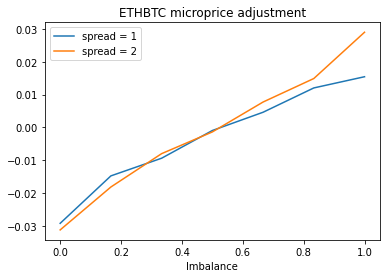

In [280]:
# plot 
imb=np.linspace(0,1,n_imb)
for i in range(0,n_spread):
    plt.plot(imb,G6[(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1))
# plt.ylim(-0.005,0.005)
plt.legend(loc='upper left')
plt.title('ETHBTC microprice adjustment')
plt.xlabel('Imbalance')

In [273]:
G6

array([-2.91716667e-03, -1.47375066e-03, -9.36510362e-04, -9.37483164e-05,
        4.62000278e-04,  1.20140204e-03,  1.54205486e-03, -3.11742834e-03,
       -1.81170267e-03, -7.97334980e-04, -1.37099022e-04,  7.72772343e-04,
        1.48758780e-03,  2.89541839e-03])